# Test case C: Learning the layout from the criterion evaluation for each row

In [96]:
import jax
import jax.numpy as jnp
from hybridoed.oed import *
import numpy as np
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [23]:
#TODO: fo a given Jacobian, evaluate the nRER for each block corresponding to a source

# load the jacobians
jacobians = jnp.load("curvel_jac_5_5_5.npy")

In [24]:
print(jacobians.shape)

transposed_jacobians = jnp.transpose(jacobians, axes=(1, 2, 0, 3))

print(transposed_jacobians.shape)


(5, 25, 25, 9800)
(25, 25, 5, 9800)


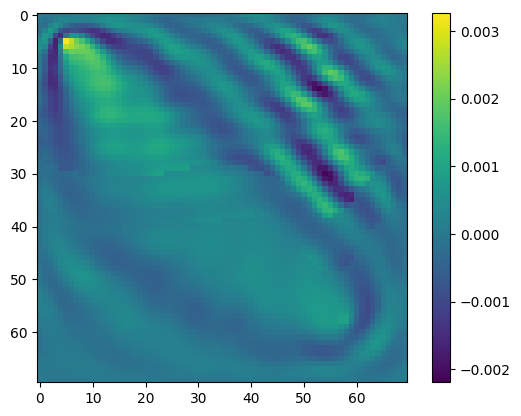

In [ ]:
# plot the jacobians
plt.figure()
plt.imshow(jacobians[-1,0,-1,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

In [26]:
# input = []
# for i in transposed_jacobians:
#     jacs_i_vstack = 
#     input.append(eigenvalue_criterion(jacobians[:,,:,:], 1e-3))

In [ ]:
stacked_array = jnp.stack([array.reshape(-1, array.shape[-1]) for array in transposed_jacobians])
stacked_array.shape

In [65]:
complex_stack_complete = []
for src in stacked_array:
    complex_stack = []
    for row in src:
        real_part = row.reshape(70,140)[:,:70]
        imaginary_part = row.reshape(70,140)[:,70:]
        complex_stack.append(real_part + 1j * imaginary_part)

    # Convert to NumPy array if needed
    complex_stack = jnp.array(complex_stack)

    print(complex_stack.shape)

    # Flatten all rows into num_rows x 4900 matrix
    num_rows = complex_stack.shape[0]
    complex_reshaped = np.empty((num_rows, 4900), dtype=np.complex128)

    for i, complex_matrix in enumerate(complex_stack):
        complex_reshaped[i, :] = complex_matrix.flatten()
    
    complex_stack_complete.append(complex_reshaped)

complex_stack_complete = jnp.array(complex_stack_complete)
print(complex_stack_complete.shape)

complex_stack_complete_2D = jnp.vstack([array for array in complex_stack_complete])
print(complex_stack_complete_2D.shape)


(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(125, 70, 70)
(25, 125, 4900)
(3125, 4900)


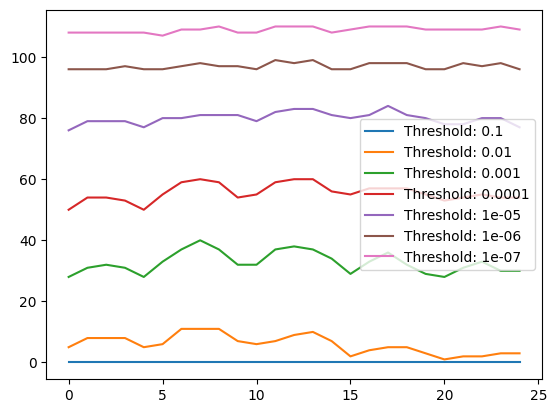

In [68]:
plt.figure()

threshold = [1e-1, 1e-2,1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
for th in threshold:
    C_sources = []
    for array in stacked_array:
        C_sources.append(eigenvalue_criterion(array, threshold=th))
    plt.plot(C_sources, label=f"Threshold: {th}")


plt.legend()
plt.show()

C_sources_1e_3 = [] 
for array in stacked_array:
    C_sources_1e_3.append(eigenvalue_criterion(array, threshold=1e-3))

C_sources_1e_3 = jnp.array(C_sources_1e_3)

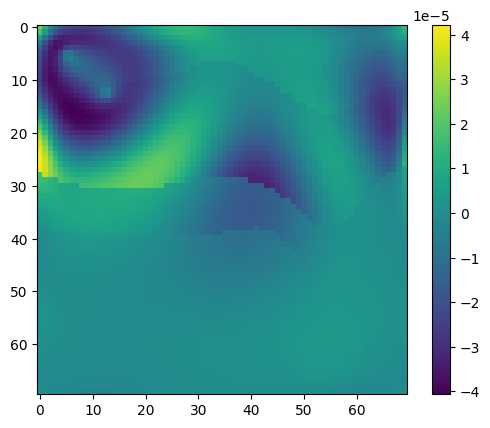

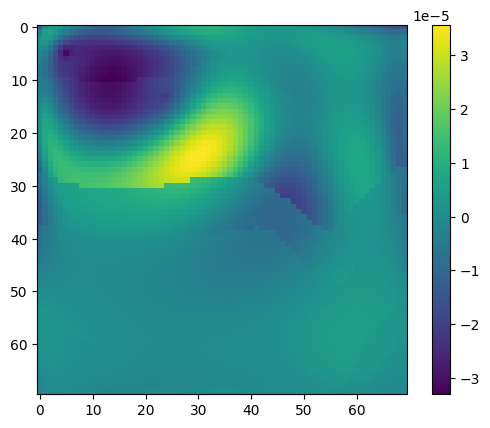

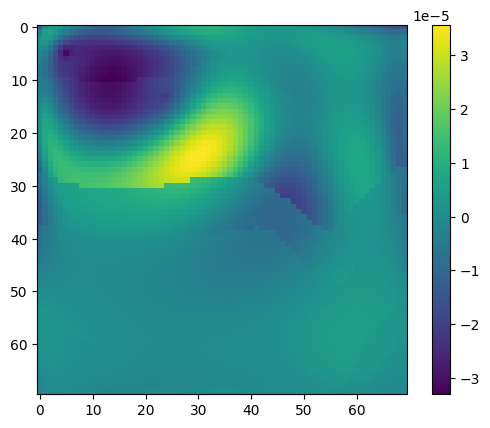

In [69]:
# plot the stacked array
plt.figure()
plt.imshow(stacked_array[0,0,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(stacked_array[0,5,:].reshape(70,140)[:,:70], cmap='viridis')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(jnp.real(complex_stack_complete[0,5,:].reshape(70,70)), cmap='viridis')
plt.colorbar()
plt.show()

In [90]:
# Fully Connected Neural Network
class FullyConnectedNN(eqx.Module):
    layers: list
    activations: list

    def __init__(self, input_size, hidden_size, num_hidden_layers, key):
        keys = jax.random.split(key, num_hidden_layers + 1)
        self.layers = [eqx.nn.Linear(input_size, hidden_size, key=keys[0])] + \
                      [eqx.nn.Linear(hidden_size, hidden_size, key=k) for k in keys[1:-1]] + \
                      [eqx.nn.Linear(hidden_size, input_size, key=keys[-1])]
        self.activations = [jax.nn.tanh] * num_hidden_layers + [jax.nn.sigmoid]

    def __call__(self, x):
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        return x

# Differentiable Mask
def differentiable_mask(probabilities, sharpness=10.0):
    return jax.nn.sigmoid(sharpness * (probabilities - 0.5))

# Differentiable Loss Function
def differentiable_loss_fn(model, x, matrix, criterion_threshold ,sharpness=10.0, mask_penalty=0.1):
    probabilities = model(x)  # Predict probabilities
    soft_mask = differentiable_mask(probabilities, sharpness)  # Generate soft mask
    # print(jnp.amax(soft_mask), jnp.amin(soft_mask))
    
    #TODO: expand the mask by repeating each row of the mask so it fits the matrix,
    # namely the number of sources, is this diffentiable?

    multiplier = matrix.shape[0] // soft_mask.shape[0]
    soft_mask = jnp.repeat(soft_mask, multiplier, axis=0)

    weighted_matrix = soft_mask[:, None] * matrix  # Apply mask to matrix rows
    # singular_values = jnp.linalg.svd(weighted_matrix, compute_uv=False)  # SVD
    # singular_loss = -jnp.sum(singular_values)  # Maximize singular values
    regularization_loss = mask_penalty * jnp.mean(soft_mask * (1 - soft_mask))  # Encourage binary mask

    singular_loss = eigenvalue_criterion(weighted_matrix, threshold=criterion_threshold)

    return singular_loss + regularization_loss*0



In [99]:
# Example Usage
key = jax.random.PRNGKey(42)
input_size = C_sources_1e_3.shape[0]
hidden_size = 56
num_hidden_layers = 3
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)

print("Model:", model)

# matrix = jax.random.normal(key, (100, 50))  # Matrix with 100 rows and 50 columns
matrix = complex_stack_complete_2D
# x = jax.random.normal(key, (input_size,))  # Input to the network
x = C_sources_1e_3

loss = differentiable_loss_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
print("Loss:", loss)

# Compute Gradients
# grads = jax.grad(differentiable_loss_fn)(model, x, matrix, sharpness=10.0, mask_penalty=0.1)

# Compute Gradients using equinox.filter_grad
# grad_fn = eqx.filter_grad(differentiable_loss_fn)
# grads = grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)

loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=1e-3, sharpness=10.0, mask_penalty=0.1)
print("Loss:", loss)


Model: FullyConnectedNN(
  layers=[
    Linear(
      weight=f32[56,25],
      bias=f32[56],
      in_features=25,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[56,56],
      bias=f32[56],
      in_features=56,
      out_features=56,
      use_bias=True
    ),
    Linear(
      weight=f32[25,56],
      bias=f32[25],
      in_features=56,
      out_features=25,
      use_bias=True
    )
  ],
  activations=[
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function tanh>,
    <wrapped function sigmoid>
  ]
)
Loss: 212.0
Loss: 212.0


In [ ]:
def train_step(model, matrix, criterion_threshold, optimizer, opt_state, x):
    loss_and_grad_fn = eqx.filter_value_and_grad(differentiable_loss_fn)
    loss, grads = loss_and_grad_fn(model, x, matrix, criterion_threshold=criterion_threshold, sharpness=10.0, mask_penalty=0.1)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Initialize the model and optimizer
key = jax.random.PRNGKey(42)
model = FullyConnectedNN(input_size, hidden_size, num_hidden_layers, key)
optimizer = optax.adamw(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))  # Initialize optimizer state

# Training loop
num_steps = 100
losses = []
for step in range(num_steps):
    loss, model, opt_state = train_step(model, matrix, 1e-3, optimizer, opt_state, x)
    losses.append(loss)

    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss}")

# Plot the losses
plt.figure()
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()


Step 0, Loss: 212.0
Step 1, Loss: 212.0
Step 2, Loss: 212.0
Step 3, Loss: 212.0
